In [22]:
import bids
import nilearn
from nilearn import image as nimg
from nilearn import plotting as nplot
import numpy as np
import pandas as pd
from bids import BIDSLayout
from nilearn.connectome import ConnectivityMeasure
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn import input_data

In [2]:
base_dir = '/home/nimhans/projects/data/PD_SERB/test_data/derivatives/fmriprep/v20.2.7/output/fmriprep/'
layout = bids.BIDSLayout(f"{base_dir}", config=['bids','derivatives'])


In [3]:
parcel_file = '../resources/rois/yeo_2011/Yeo_JNeurophysiol11_MNI152/relabeled_yeo_atlas.nii.gz'
yeo_7 = nimg.load_img(parcel_file)

# Get the label numbers from the atlas
atlas_labels = np.unique(yeo_7.get_fdata().astype(int))

# Get number of labels that we have
NUM_LABELS = len(atlas_labels)
print(NUM_LABELS)

masker = input_data.NiftiLabelsMasker(labels_img=yeo_7,
                                      standardize=True,
                                      memory='nilearn_cache',
                                      verbose=1,
                                      detrend=True,
                                     low_pass = 0.08,
                                     high_pass = 0.009,
                                     t_r=0.69)

50


### Single participants

In [4]:
from itertools import count


def get_fmri_data(subject_id):
    func_files = layout.get(subject=subject_id,
                        datatype='func', task='rest',
                        desc='preproc',
                        space='MNI152NLin2009cAsym',
                        extension='nii.gz',
                        return_type='file')

    mask_files = layout.get(subject=subject_id,
                            datatype='func', task='rest',
                            desc='brain',
                            suffix="mask",
                            space='MNI152NLin2009cAsym',
                            extension='nii.gz',
                            return_type='file')

    confound_files = layout.get(subject=subject_id,
                                datatype='func',
                                task='rest',
                                desc='confounds',
                                extension='tsv',
                                return_type='file')
                                
    # Pull the first subject's data
    func_file = func_files[0]
    mask_file = mask_files[0]
    confound_file = confound_files[0]
                            
    return func_file, mask_file, confound_file


def extract_confounds(confound_tsv,confounds,dt=True):
    '''
    Arguments:
        confound_tsv                    Full path to confounds.tsv
        confounds                       A list of confounder variables to extract
        dt                              Compute temporal derivatives [default = True]
        
    Outputs:
        confound_mat                    
    '''
    
    if dt:    
        dt_names = ['{}_derivative1'.format(c) for c in confounds]
        confounds = confounds + dt_names
    
    #Load in data using Pandas then extract relevant columns
    confound_df = pd.read_csv(confound_tsv,delimiter='\t') 
    confound_df = confound_df[confounds]
    
 
    #Convert into a matrix of values (timepoints)x(variable)
    confound_mat = confound_df.values 
    
    #Return confound matrix
    return confound_mat

In [5]:
def get_correlation_matrix(subject_id, tr_drop=4): 
    func_file, mask_file, confound_file = get_fmri_data(subject_id)

    func_img = nimg.load_img(func_file)

    #Remove the first 4 TRs
    func_img = func_img.slicer[:,:,:,tr_drop:]

    #Use the above function to pull out a confound matrix
    confounds = extract_confounds(confound_file,
                                ['trans_x','trans_y','trans_z',
                                'rot_x','rot_y','rot_z',
                                'global_signal',
                                'white_matter','csf'])
    #Drop the first 4 rows of the confounds matrix
    confounds = confounds[tr_drop:,:] 
    cleaned_and_averaged_time_series = masker.fit_transform(func_img,confounds)

    # Remember fMRI images are of size (x,y,z,t)
    # where t is the number of timepoints
    num_timepoints = func_img.shape[3]

    # Create an array of zeros that has the correct size
    final_signal = np.zeros((num_timepoints, NUM_LABELS))

    # Get regions that are kept
    regions_kept = np.array(masker.labels_)

    # Fill columns matching labels with signal values
    final_signal[:, regions_kept] = cleaned_and_averaged_time_series

    correlation_measure = ConnectivityMeasure(kind='correlation')

    full_correlation_matrix = correlation_measure.fit_transform([cleaned_and_averaged_time_series])

    return full_correlation_matrix

In [9]:
# group_list = ["control", "PD"]
# correlation_matrix_list = []
# for subject_id in ["BLR03"]:
#     full_correlation_matrix = get_correlation_matrix(subject_id)
#     correlation_matrix_list.append(full_correlation_matrix)
    

### Simulating random edge values by adding gaussian noise

In [15]:
n_samples = 100
control_random_noise = (0.1) * np.random.random(n_samples)
pd_random_noise = (-0.1) * np.random.random(n_samples)


In [17]:
edge = (43,45)
base_correlation_matrix = np.squeeze(full_correlation_matrix)

control_edge = np.tile(base_correlation_matrix[edge[0],edge[1]], n_samples) + control_random_noise
PD_edge = np.tile(base_correlation_matrix[edge[0],edge[1]], n_samples) + pd_random_noise


In [20]:
corr_df = pd.DataFrame(columns=["subject_id","edge","group"])

corr_df["subject_id"] = np.arange(2*n_samples)
corr_df["edge"] = list(control_edge) + list(PD_edge)
corr_df["group"] = list(np.tile(["control"], reps=100)) + list(np.tile(["PD"], reps=100))

corr_df

,subject_id,edge,group
0,0,0.529061,control
1,1,0.481170,control
2,2,0.555770,control
3,3,0.531310,control
4,4,0.541726,control
...,...,...,...
195,195,0.423887,PD
196,196,0.386324,PD
197,197,0.407415,PD
198,198,0.441868,PD


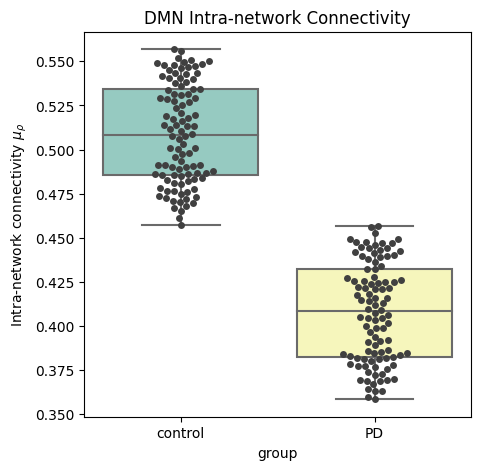

In [23]:
plot = plt.figure(figsize=(5,5))
                  
# Create a box plot, with the x-axis as group
#the y-axis as the correlation value
ax = sns.boxplot(x='group',y='edge',data=corr_df, palette='Set3')

# Create a "swarmplot" as well, you'll see what this is..
ax = sns.swarmplot(x='group',y='edge',data=corr_df,color='0.25')

# Set the title and labels of the figure
ax.set_title('DMN Intra-network Connectivity')
ax.set_ylabel(r'Intra-network connectivity $\mu_\rho$')

plt.show()
